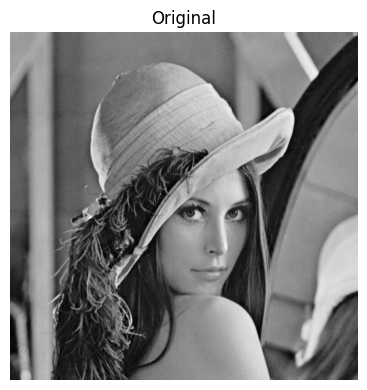

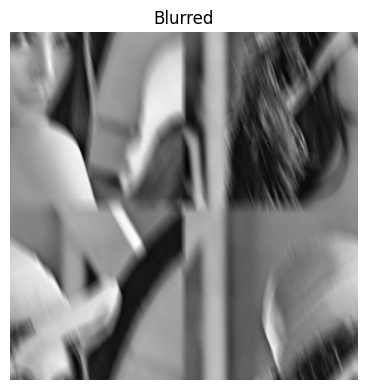

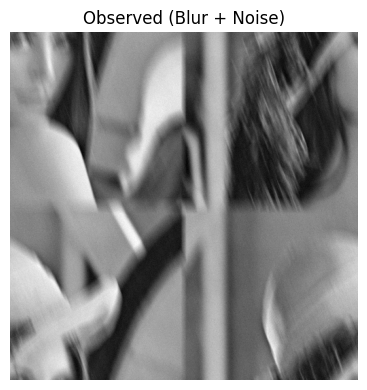

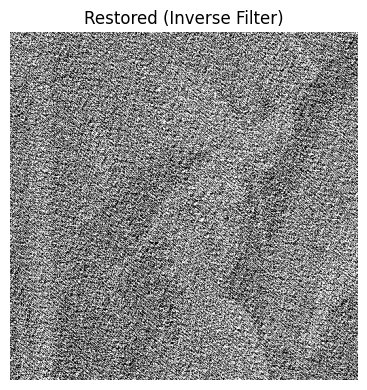

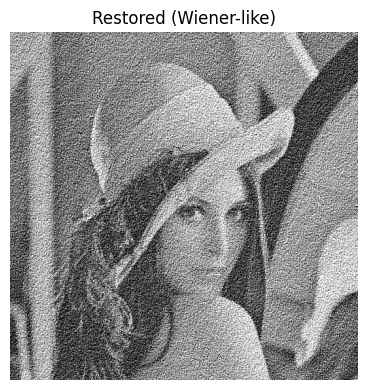

In [1]:

import numpy as np
import cv2
from numpy.fft import fft2, ifft2, fftshift
import matplotlib.pyplot as plt

def load_grayscale(path):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise FileNotFoundError(f"Could not read image at {path}")
    return img.astype(np.float32) / 255.0

def gaussian_psf(shape, sigma=2.0):
    """Create a centered Gaussian Point Spread Function (PSF)."""
    h, w = shape
    y, x = np.indices((h, w))
    cy, cx = h // 2, w // 2
    gauss = np.exp(-((x - cx)**2 + (y - cy)**2) / (2 * sigma**2))
    gauss /= gauss.sum() + 1e-12
    return gauss

def motion_psf(shape, length=15, angle=0.0):
    """Create a simple linear motion blur PSF."""
    h, w = shape
    psf = np.zeros((h, w), dtype=np.float32)
    # draw a line on the center based on angle and length
    cy, cx = h // 2, w // 2
    # parametric line
    theta = np.deg2rad(angle)
    dy = np.cos(theta)
    dx = np.sin(theta)
    for i in range(length):
        yy = int(cy + (i - length//2) * dy)
        xx = int(cx + (i - length//2) * dx)
        if 0 <= yy < h and 0 <= xx < w:
            psf[yy, xx] = 1.0
    psf /= psf.sum() + 1e-12
    return psf

def psf_to_otf(psf, shape):
    """
    Convert PSF to OTF (Optical Transfer Function) by zero-padding and FFT.
    PSF should be centered.
    """
    pad = np.zeros(shape, dtype=np.float32)
    ph, pw = psf.shape
    sh, sw = shape
    # place PSF in the center of pad
    y0 = (sh - ph) // 2
    x0 = (sw - pw) // 2
    pad[y0:y0+ph, x0:x0+pw] = psf
    # circularly shift so that PSF center is at (0,0) for FFT
    pad = np.roll(pad, -y0, axis=0)
    pad = np.roll(pad, -x0, axis=1)
    otf = fft2(pad)
    return otf

def add_gaussian_noise(img, sigma=0.01):
    noise = np.random.normal(0, sigma, img.shape).astype(np.float32)
    noisy = np.clip(img + noise, 0.0, 1.0)
    return noisy

def inverse_filter(observed, otf, eps=1e-3):
    """
    Inverse filtering: F = G / (H + eps)
    eps prevents division by zero or near-zero in OTF.
    """
    G = fft2(observed)
    denom = otf + eps
    F_hat = G / denom
    restored = np.real(ifft2(F_hat))
    restored = np.clip(restored, 0.0, 1.0)
    return restored

def inverse_filter_wiener(observed, otf, K=1e-4):
    """
    Wiener-like stabilization:
    F = G * H* / (|H|^2 + K)
    K relates to noise/signal ratio; larger K -> more smoothing.
    """
    G = fft2(observed)
    H = otf
    H_conj = np.conj(H)
    denom = (np.abs(H)**2 + K)
    F_hat = (G * H_conj) / denom
    restored = np.real(ifft2(F_hat))
    restored = np.clip(restored, 0.0, 1.0)
    return restored

def show(title, img):
    plt.figure(figsize=(5,4))
    plt.imshow(img, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

path = "sample image.png"  # <-- change this
img = load_grayscale(path)
psf = motion_psf(img.shape, length=25, angle=20.0)
otf = psf_to_otf(psf, img.shape)
F = fft2(img)
G_clean = F * otf
blurred = np.real(ifft2(G_clean))
blurred = np.clip(blurred, 0.0, 1.0)
observed = add_gaussian_noise(blurred, sigma=0.01)
restored_inv = inverse_filter(observed, otf, eps=1e-3)
restored_wiener = inverse_filter_wiener(observed, otf, K=1e-4)
show("Original", img)
show("Blurred", blurred)
show("Observed (Blur + Noise)", observed)
show("Restored (Inverse Filter)", restored_inv)
show("Restored (Wiener-like)", restored_wiener)